In [1]:
# IMPORTS
import requests
import json
from sportmonks.soccer import SoccerApiV2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import xlsxwriter
import excel2json
from datetime import datetime
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
//anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
# JSON FORMAT PRINT
def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

In [3]:
# API key
soccer = SoccerApiV2(api_token='kDasthE00jpkFjEERAZNFyE9a79LNX3tPeaAqlhB3s2NhckJbKDhyL94j7AO')

In [ ]:
# START AND END DATE 
start_date = "2018-08-10"
end_date = "2019-05-12"

# EMPTY LIST FOR ALL THE VARIABLES
lijst = []
sub_list = []
sub_list_min = []

# START QUERY
ids = soccer.fixtures(start_date, end_date, includes=('lineup', 'substitutions', 'venue'))

# CHANGE THIS LIST TO THE FEATURES YOU APPED
inhoud = ['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Venue', 'Injured'] 
# inhoud = ['Position', 'Minutes_played', 'Day_since_start', 'Venue', 'Injured'] 
lijst.append(inhoud)

# FOR LOOP TO GET ALL THE FIXTURES IN BETWEEN THE START AND END DATE
for f in ids:
    team = []
    index = 0
    
    # WHILE LOOP TO GET EVERY PLAYER OF THE LINEUP
    while len(team) < len(f['lineup']):
        speler = []
        minutes = 0
        
        # STANDARD FEATURES (name, position, minutes played, day since start date, injury)
        
        # NAME PLAYER
        name = f['lineup'][index]['player_name']
        
#         for speler in lijst:
#             if speler[0] == name:
#                 print('speler al geweest')
        
        
        speler.append(name)
        team.append(speler)
        
#         name = f['lineup'][index]['player_name']
#         team.append(name)    
    
    
    
        # POSITION PLAYER
        position = f['lineup'][index]['position']
        speler.append(position)
        
        # MINUTES PLAYED
        minutes = f['lineup'][index]['stats']['other']['minutes_played']
        if minutes == None:
            minutes = 0
        speler.append(minutes)
        
        # DAY SINCE START DATE
        current_date = f["time"]["starting_at"]["date"]
        date_format = "%Y-%m-%d"
        a = datetime.strptime(start_date, date_format)
        b = datetime.strptime(current_date, date_format)
        delta = b - a
        speler.append(delta.days)
        
        
        # VARIABLE FEATURES 
        
        # VENUE SURFACE MATCH
        venue = f['venue']['surface']
        speler.append(venue)
        
        
        
        # TARGET VALUE IF THE PLAYER IS INJURED
        
        # INJURY
        injury_index = 0 
        injured = 'null'
        while injury_index < len(f['substitutions']):
            sub = []
            player_name = name.split(' ')
            sub_name = f['substitutions'][injury_index]['player_out_name']
            sub_name_split = sub_name.split(' ')  
            if player_name[-1] == sub_name_split[-1]:
                injured = f['substitutions'][injury_index]['injuried']
                break
            else:
                injury_index += 1
        if injured == True :
            speler.append('Yes')
        else:
            speler.append('No')
        
        # APPEND THE PLAYER TO THE BIG LIST
        lijst.append(speler)
        index += 1


print(lijst)

In [52]:
index = 0
for element in ajax['Minutes_played']:
    if element == "":
        element = 0.0
    if isinstance(element, float) != True:
        print('dit is helemaal fout')
        print(element)
#         print(float(element))
        print(type(element))
        print(index)
#         print(ajax['Minutes_played'].index(element))
    index += 1

In [55]:
# CODE TO EXPORT TO EXCEL 
with xlsxwriter.Workbook('ajaxsurface.xlsx') as workbook:
    worksheet = workbook.add_worksheet()

    for row_num, data in enumerate(lijst):
        worksheet.write_row(row_num, 0, data)

# CODE TO CONVERT EXCEL FILE TO JSON --> (Sheet1.json)
excel2json.convert_from_file('ajaxsurface.xlsx')


In [56]:
# READ THE JOSN FILE AND PRINT HEAD
ajax = pd.read_json("Sheet1.json")
print(ajax)

                    Name Position  Minutes_played  Day_since_start  \
0          Diederik Boer        G              90                0   
1      Kingsley Ehizibue        D              90                0   
2         Darryl Lachman        D              90                0   
3         Dirk Marcellis        D              90                0   
4         Bram Van Polen        D              90                0   
...                  ...      ...             ...              ...   
6513      José Rodríguez        M              90              275   
6514       Jorrit Smeets        M              90              275   
6515        Mark Diemers        M              76              275   
6516       Finn Stokkers        A              90              275   
6517  Andrija Novakovich        A              64              275   

                Venue Injured  
0     artificial turf      No  
1     artificial turf      No  
2     artificial turf      No  
3     artificial turf      No  

In [57]:
# inhoud = ['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Injuried', 'Venue'] 

le = preprocessing.LabelEncoder()

ajax['Name'] = le.fit_transform(ajax['Name'])
ajax['Position'] = le.fit_transform(ajax['Position'])
ajax['Venue'] = le.fit_transform(ajax['Venue'])
ajax['Injured'] = le.fit_transform(ajax['Injured'])

In [58]:
Y = ajax.Injured
X = ajax.drop('Injured', axis = 1)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [60]:
classifier = DecisionTreeClassifier(random_state=0, max_depth=None)
classifier.fit(X_train_val, y_train_val)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [61]:
# PREDICT VALIDATION
y_pred = classifier.predict(X_val)

In [62]:
# PRINT ACCURACY SCORE
print(accuracy_score(y_val, y_pred))

0.9731543624161074


In [63]:
# # TRANSFORM LABELS BACK TO ORIGINAL ENCODING
# print(ajax['Injured'])
ajax['Injured'] = le.inverse_transform(ajax['Injured'])
# print(ajax['Injured'])

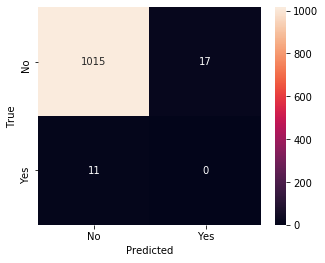

In [64]:
# PRINT CONFUSION MATRIX
features = ajax['Injured'].unique()
confusion_val = pd.DataFrame(confusion_matrix(y_val, y_pred),columns=features,index=features)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_val, annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [65]:
# PREDICT TEST 
y_pred = classifier.predict(X_test)

In [66]:
# PRINT ACCURACY SCORE
print(accuracy_score(y_test, y_pred))

0.977760736196319


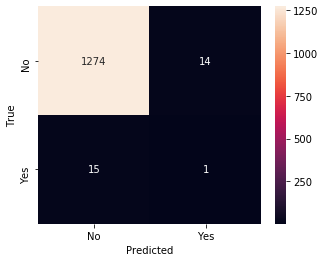

In [67]:
# PRINT CONFUSION MATRIX
features = ajax['Injured'].unique()
confusion_test = pd.DataFrame(confusion_matrix(y_test,y_pred),columns=features,index=features)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_test,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

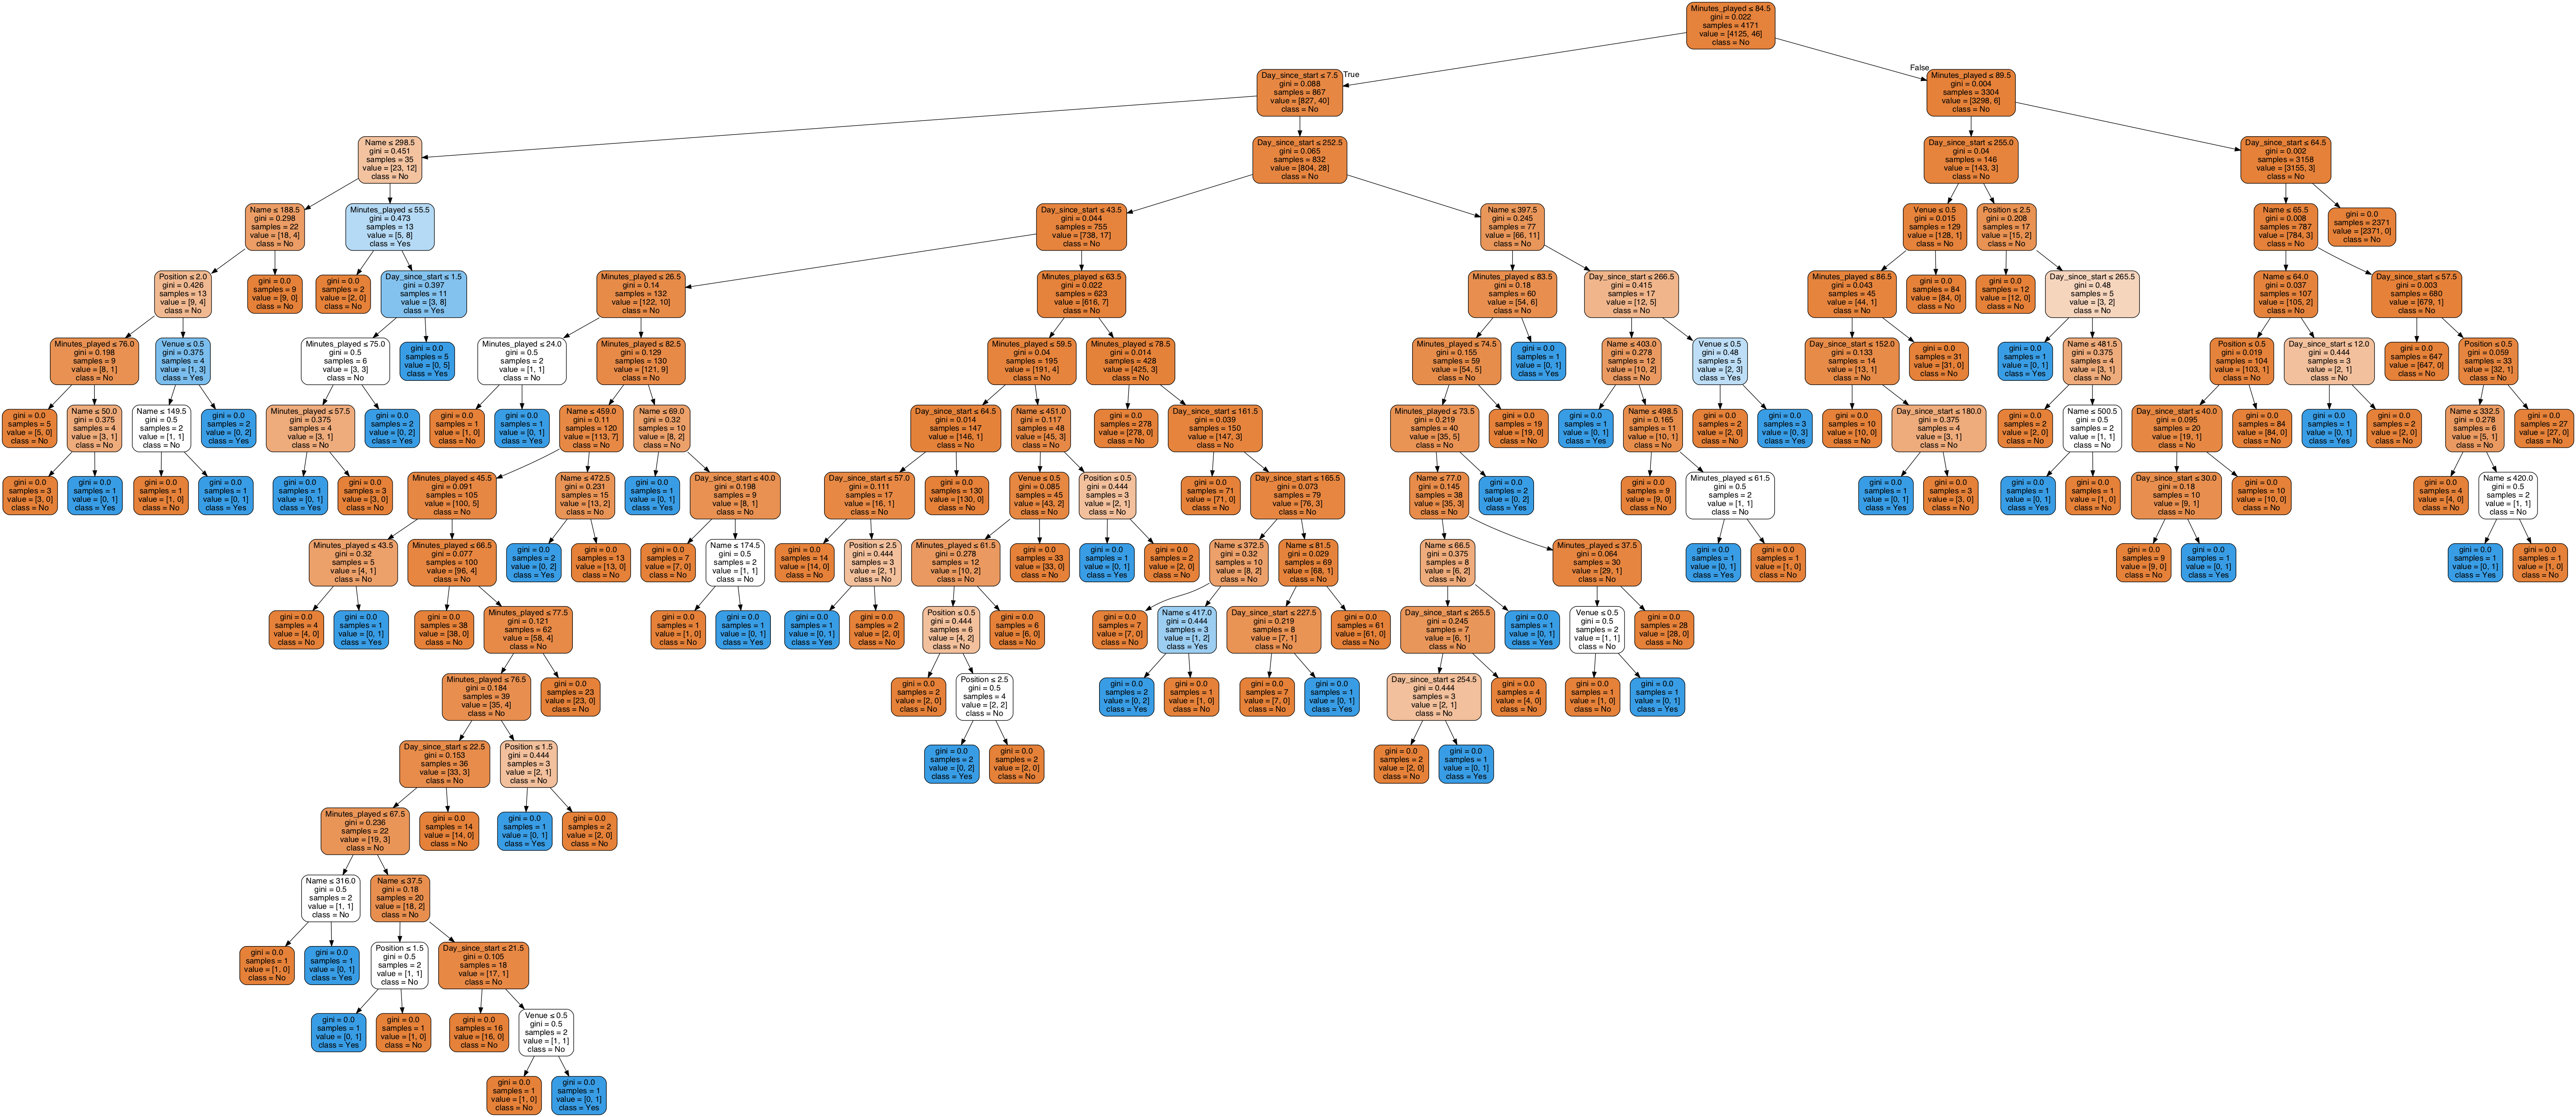

In [68]:
feature_cols = ['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Venue'] 

dot_data = StringIO()
export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols, class_names=['No','Yes'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('predictions.png')
Image(graph.create_png())

In [64]:
spelers = lijst[1:]
arti_yes = 0
arti_no = 0
grass_yes = 0
grass_no = 0
for element in spelers:
    if element[4] == 'artificial turf' and element[5] == 'Yes':
        arti_yes += 1
    elif element[4] == 'artificial turf' and element[5] == 'No':
        arti_no += 1
    elif element[4] == 'grass' and element[5] == 'Yes':
        grass_yes += 1
    elif element[4] == 'grass' and element[5] == 'No':
        grass_no += 1
    else:
        print('hier gaat iets mis')
        
print('artificial yes:', arti_yes)
print('artificial no:', arti_no)

print('grass yes:', grass_yes)
print('grass no:', grass_no)


artificial yes: 6
artificial no: 147
grass yes: 13
grass no: 426


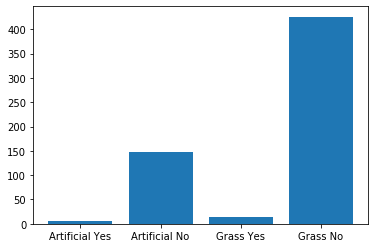

In [65]:
bars = ('Artificial Yes', 'Artificial No', 'Grass Yes', 'Grass No')
height = [arti_yes, arti_no, grass_yes, grass_no]
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
 
# Show graphic
plt.show()